# Clasificación Supervisada

### OBJETIVO

- Aplicar los algoritmos de Clasificación Supervisada aprendidos en esta sesión a nuestro proyecto

## Regresión logística

En este notebook se presenta la aplicación de la técnica de machine learning de regresión logística a un dataset sobre información sobre si unos clientes realizaron una compra en cierta empresa.

Al no ser este el dataset del proyecto, se tendrá que realizar brevemente la exploración de los datos.

In [1]:
#Lectura de los paquetes a utilizar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

## Exploración inicial de los datos

In [2]:
#Lectura del dataset y primera visualización
df= pd.read_csv('../Datasets/RFMdata.csv')
df.head()

,Id,Recency,Frequency,Monetary,Purchase
0,1,120,7,41.66,0
1,2,90,9,46.71,0
2,3,120,6,103.99,1
3,4,270,17,37.13,1
4,5,60,5,88.92,0


In [3]:
df.dtypes

Id             int64
Recency        int64
Frequency      int64
Monetary     float64
Purchase       int64
dtype: object

Según la documentación de del proveedor de los datos, la descripción de las variables es la siguiente:
* Id: El id del cliente
* Recency: Hace cuántos días un cliente realizó una compra, tomando como referencia una fecha no especificada.
* Frecuency: Cuántas veces un cliente ha comprado.
* Monetary: Cuánto dinero ha gastado en total el cliente.
* Purchase: información sobre si un cliente realizó una compra, 1 es que sí, 0 es que no en cierto tiempo


Se procede a colocar el ID como el índice y a eliminar los datos NA si los hubiera.

In [4]:
df= df.set_index('Id')
df.head()

,Recency,Frequency,Monetary,Purchase
Id,,,,
1,120,7,41.66,0
2,90,9,46.71,0
3,120,6,103.99,1
4,270,17,37.13,1
5,60,5,88.92,0


In [5]:
len(df)

100

In [6]:
len(df.dropna(axis=0, how='any'))


100

Vemos que no hay ningún dato NA, y que tenemos actualmente 100 datos de distintos clientes.

Ahora realizaremos un pairplot para observar la interacción entre las variables distinguiendo si el registro corresponde a si se realizó una compra o no.

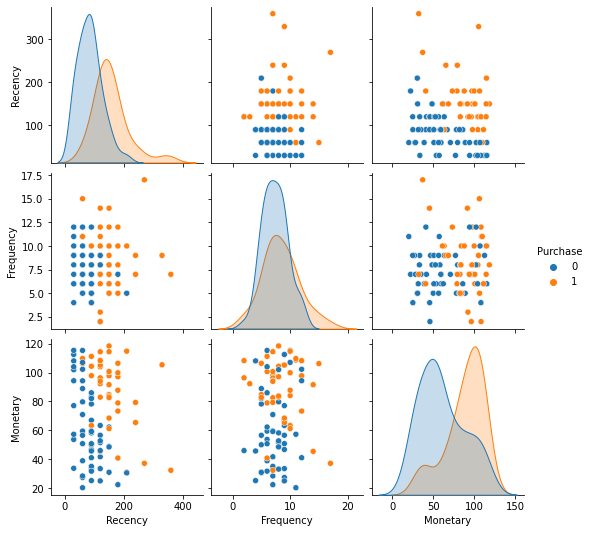

In [7]:
sns.pairplot(df, hue='Purchase');

De manera general, observamos una diferencia entre los grupos en la interacción de las variables, por lo que podríamos utilizar estos datos para ajustar un modelo de regresión logística.

Además, aunque los datos parezcan estar sesgados, no parecen haber datos atípicos en el dataset. Por lo que procederá a utilizar todos los registros para el siguiente paso.

## Ajuste del Modelo de Regresión Logística
Ajustamos nuestro modelo de regresión logística, dividiendo el dataset en el conjunto de prueba y el conjunto de validación.

In [8]:
logreg= LogisticRegression(max_iter=10_000)

In [9]:
X= df.drop(columns=['Purchase'])
X.head()

,Recency,Frequency,Monetary
Id,,,
1,120,7,41.66
2,90,9,46.71
3,120,6,103.99
4,270,17,37.13
5,60,5,88.92


In [10]:
y= df['Purchase']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Ahora ajustamos el modelo utilizando el conjunto de prueba y comprobamos utilizando el conjunto de validación.

In [12]:
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0])

In [13]:
logreg.score(X_test, y_test)

0.9

En primera instancia, podemos observar que el modelo fue capaz de predecir correctamente el 90% de los datos.

En la siguiente sección exploraremos más medidas para describir la exactitud de nuestro modelo de regresión logística.

## Evaluación del modelo
### Matriz de precisión

In [14]:
from sklearn import metrics

In [15]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[12,  1],
       [ 1,  6]])

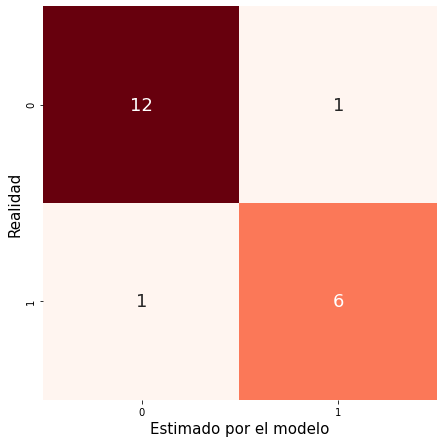

In [16]:
class_names=[0,1] 
fig, ax = plt.subplots(figsize=(6, 6))
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Reds" ,fmt='g', cbar=False, annot_kws={"size": 18})
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.ylabel('Realidad', fontsize=15, y=0.5)
plt.xlabel('Estimado por el modelo', fontsize=15);


Observamos que el modela solamente tuvo un falso positivo y un falso negativo en el conjunto de prueba. Por su parte tuvo 12 verdaderos negativos y 6 verdaderos positivos.

Con esta matriz de confusión creada, utilizaremos los distintas medidas de evaluación para poder reportar nuestros resultados.

In [17]:
vn, fp, fn,vp = cnf_matrix.ravel()
print("Las medidas de evaluación del modelo de regresión logística son:")
print("Precisión:",round(metrics.precision_score(y_test, y_pred),4)) # VP / (VP + FP)
print("Exactitud:",round(metrics.accuracy_score(y_test, y_pred),4)) #(VP + VN) / (VP + FN + FP + VN)
print("Sensibilidad:",round(metrics.recall_score(y_test, y_pred),4)) #VP / (VP + FN)
print("Especificidad:", round(vn / (vn + fp),4)) #VN / (VN + FP)

Las medidas de evaluación del modelo de regresión logística son:
Precisión: 0.8571
Exactitud: 0.9
Sensibilidad: 0.8571
Especificidad: 0.9231


Con esto, concluímos que:


1.   Aproximadamente el 86% de las clasificaciones como "compra realizada" hechas fueron realmente compras realizadas.
2.   El 90% del total de las clasificaciones fueron realizadas de manera correcta.
3. Aproximadamente el 86% de las compras realizadas fueron clasificadas de manera correcta.
4. Aproximadamente el 92% de las compras no realizadas fueron clasificadas correctamente.


### Curva ROC / AUC
Ahora, observaremos la curva ROC/AUC, la cual nos mostrará más detalles sobre el ajuste del modelo.

Para poder generar la curva primero necesitamos los datos probabilisticos de las predicciones en el conjunto de prueba. En este caso, el primer elemento del vector para cada ID, será la probabilidad de que el cliente no haya realizado una compra y el segundo elemento es la probabilidad que el cliente haya realizado una compra.

In [18]:
y_pred_proba = logreg.predict_proba(X_test)
y_pred_proba[:10,:]

array([[9.61815429e-01, 3.81845714e-02],
       [9.59269064e-01, 4.07309357e-02],
       [8.70882712e-01, 1.29117288e-01],
       [9.88274258e-01, 1.17257419e-02],
       [2.26350079e-01, 7.73649921e-01],
       [9.99951364e-01, 4.86363453e-05],
       [9.99138878e-01, 8.61121853e-04],
       [9.99999905e-01, 9.45182743e-08],
       [4.39156178e-05, 9.99956084e-01],
       [9.59754210e-01, 4.02457905e-02]])

In [19]:
#Importando la curva ROC y AUC
from sklearn.metrics import roc_curve, auc

In [20]:
fpr, vpr, _ = roc_curve(y_test, y_pred_proba[:, 1]) #Obtener el incremento del falso positivo, incremento del verdadero positivo
roc_auc = auc(fpr, vpr) #Área bajo la curva utilizando los incrementos en falsos positivos y los incrementos de verdaderos positivos

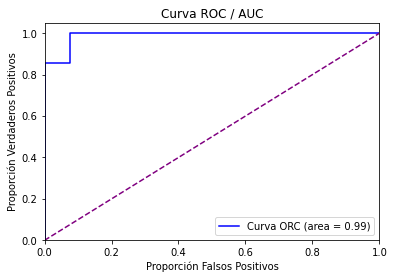

In [21]:
plt.figure()
plt.plot(fpr, vpr, color='blue',
         label='Curva ORC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Falsos Positivos')
plt.ylabel('Proporción Verdaderos Positivos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()

El valor de 0.95 para nuestra curva ORC nos indica que nuestro modelo es muy eficaz identificando negativos y positivos, y puede ser capaz de predecir si un cliente comprará o no de acuerdo a sus datos sobre hace cuántos días realizó una compra (Recency), cuántas veces un cliente ha comprado (Frecuency) y cuánto dinero ha gastado en total (Monetary)